In [ ]:
!wget -O "dataset.zip" "https://data.mendeley.com/public-files/datasets/g46dvrcvwn/files/60aa59c1-cd77-4c8a-9573-50d2fd8b10e9/file_downloaded"

--2025-10-13 18:42:37--  https://data.mendeley.com/public-files/datasets/g46dvrcvwn/files/60aa59c1-cd77-4c8a-9573-50d2fd8b10e9/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/6fa5ad64-11e3-451a-84a9-d834be2517ec [following]
--2025-10-13 18:42:38--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/6fa5ad64-11e3-451a-84a9-d834be2517ec
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 3.5.64.166, 3.5.64.71, 3.5.69.128, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|3.5.64.166|:443... conne

In [ ]:
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
   creating: Turmeric Plant Disease Augmented Dataset/
   creating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/
  inflating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/Dry Leaf00001_aug_0.jpg  
  inflating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/Dry Leaf00001_aug_1.jpg  
  inflating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/Dry Leaf00001_aug_2.jpg  
  inflating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/Dry Leaf00001_aug_3.jpg  
  inflating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/Dry Leaf00002_aug_4.jpg  
  inflating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/Dry Leaf00002_aug_5.jpg  
  inflating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/Dry Leaf00002_aug_6.jpg  
  inflating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/Dry Leaf00002_aug_7.jpg  
  inflating: Turmeric Plant Disease Augmented Dataset/Dry Leaf/Dry Leaf00003_aug_10.jpg  
  inflating: Turmeric Plant Disease Augmented Da

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio("/content/Turmeric Plant Disease Augmented Dataset", output="dataset", seed=1337, ratio=(.8, .1,.1))


Copying files: 4548 files [00:13, 343.36 files/s]


**Data Preprocessing**

In [ ]:
train_dir = "/content/dataset/train"
validation_dir = "/content/dataset/val"

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 3637 files belonging to 5 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dir = "/content/dataset/test"
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 453 files belonging to 5 classes.
Found 458 files belonging to 5 classes.


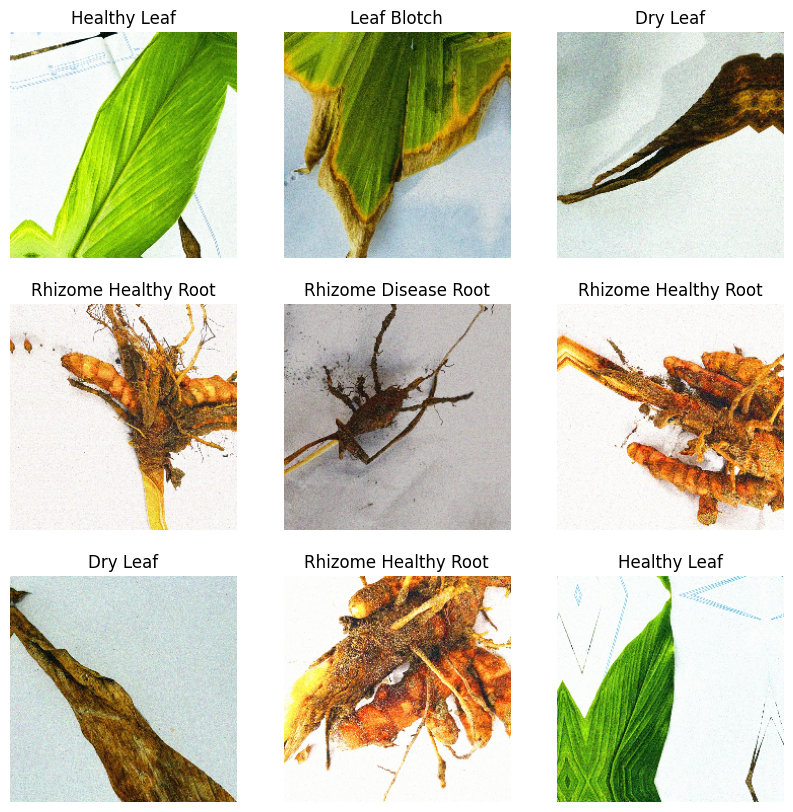

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
class_names

['Dry Leaf',
 'Healthy Leaf',
 'Leaf Blotch',
 'Rhizome Disease Root',
 'Rhizome Healthy Root']

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

**Create the base model from the pre-trained convnets**

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB4(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1792)


## **Feature extraction**
**Freeze the convolutional base**

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "efficientnetb4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      1,152 │ block1a_se_excit

 Total params: 17,673,823 (67.42 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17,673,823 (67.42 MB)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1792)


In [ ]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 7, 7, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         8,965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,682,788 (67.45 MB)

 Trainable params: 8,965 (35.02 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [ ]:
len(model.trainable_variables)

2

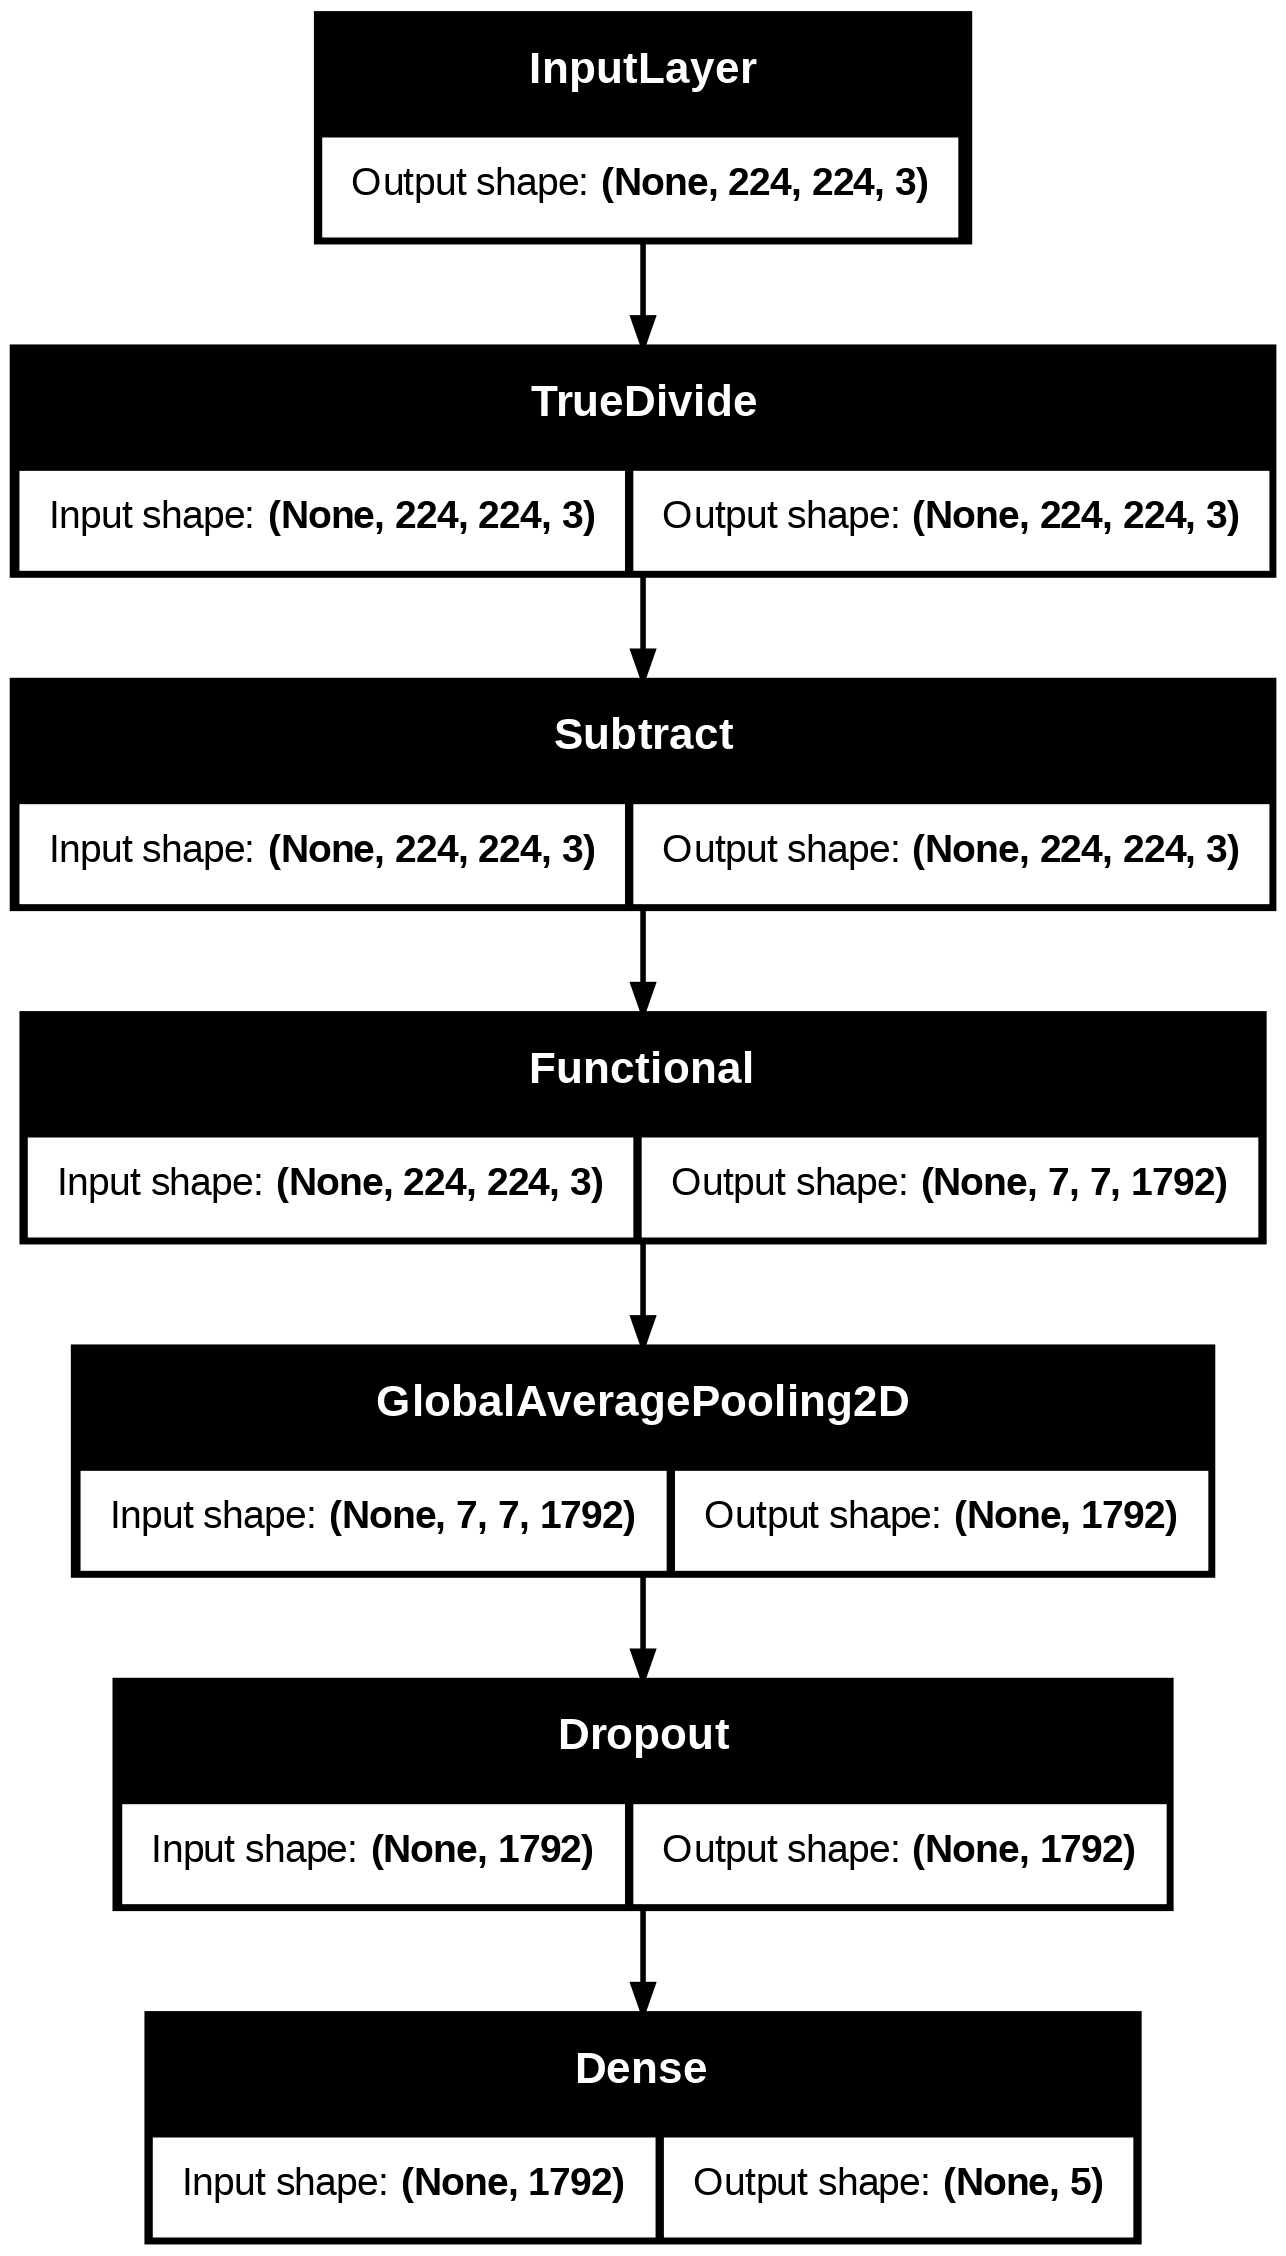

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [ ]:
initial_epochs = 6

loss0, accuracy0 = model.evaluate(validation_dataset)

15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2139 - loss: 1.6223


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.63
initial accuracy: 0.20


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/6
114/114 ━━━━━━━━━━━━━━━━━━━━ 104s 545ms/step - accuracy: 0.3051 - loss: 1.5370 - val_accuracy: 0.4945 - val_loss: 1.3111
Epoch 2/6
114/114 ━━━━━━━━━━━━━━━━━━━━ 33s 293ms/step - accuracy: 0.4484 - loss: 1.3192 - val_accuracy: 0.5254 - val_loss: 1.2158
Epoch 3/6
114/114 ━━━━━━━━━━━━━━━━━━━━ 34s 300ms/step - accuracy: 0.4816 - loss: 1.2411 - val_accuracy: 0.5188 - val_loss: 1.1712
Epoch 4/6
114/114 ━━━━━━━━━━━━━━━━━━━━ 33s 286ms/step - accuracy: 0.4954 - loss: 1.2102 - val_accuracy: 0.5408 - val_loss: 1.1264
Epoch 5/6
114/114 ━━━━━━━━━━━━━━━━━━━━ 43s 305ms/step - accuracy: 0.4983 - loss: 1.1803 - val_accuracy: 0.5651 - val_loss: 1.0920
Epoch 6/6
114/114 ━━━━━━━━━━━━━━━━━━━━ 42s 311ms/step - accuracy: 0.4984 - loss: 1.1741 - val_accuracy: 0.5960 - val_loss: 1.0752


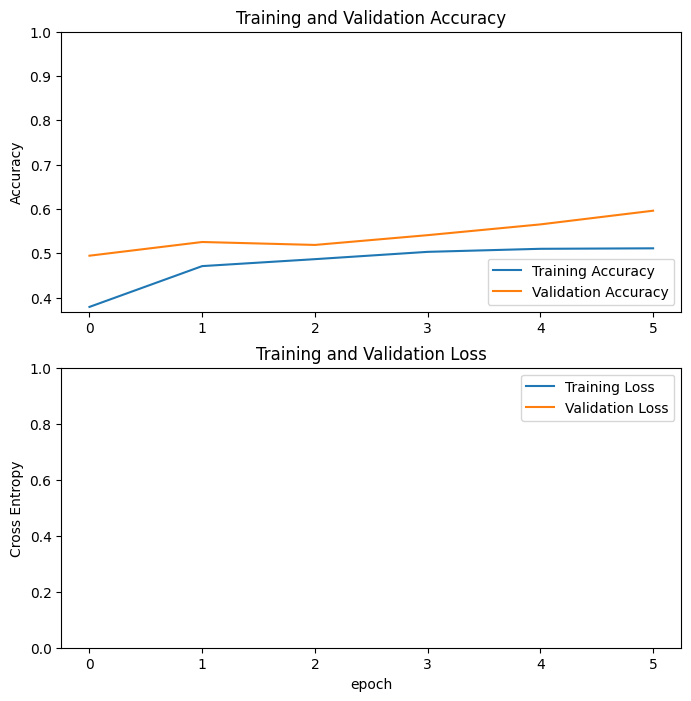

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  475


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [ ]:
# Get current learning rate
lr = model.optimizer.learning_rate
print("Current Learning Rate:", tf.keras.backend.get_value(lr))



Current Learning Rate: 0.001


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 7, 7, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         8,965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,624,432 (200.75 MB)

 Trainable params: 17,470,821 (66.65 MB)

 Non-trainable params: 211,967 (828.00 KB)

 Optimizer params: 34,941,644 (133.29 MB)

In [ ]:
len(model.trainable_variables)

333

In [ ]:
fine_tune_epochs = 10
initial_epochs = 6 # Redefine initial_epochs
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 7/16
114/114 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.8130 - loss: 0.5152 - val_accuracy: 0.7770 - val_loss: 0.7956
Epoch 8/16
114/114 ━━━━━━━━━━━━━━━━━━━━ 36s 317ms/step - accuracy: 0.9627 - loss: 0.1183 - val_accuracy: 0.9669 - val_loss: 0.1318
Epoch 9/16
114/114 ━━━━━━━━━━━━━━━━━━━━ 37s 320ms/step - accuracy: 0.9842 - loss: 0.0548 - val_accuracy: 0.9691 - val_loss: 0.0965
Epoch 10/16
114/114 ━━━━━━━━━━━━━━━━━━━━ 41s 316ms/step - accuracy: 0.9845 - loss: 0.0452 - val_accuracy: 0.9845 - val_loss: 0.0456
Epoch 11/16
114/114 ━━━━━━━━━━━━━━━━━━━━ 41s 318ms/step - accuracy: 0.9787 - loss: 0.0689 - val_accuracy: 0.9890 - val_loss: 0.0312
Epoch 12/16
114/114 ━━━━━━━━━━━━━━━━━━━━ 42s 326ms/step - accuracy: 0.9914 - loss: 0.0329 - val_accuracy: 0.8609 - val_loss: 0.3054
Epoch 13/16
114/114 ━━━━━━━━━━━━━━━━━━━━ 37s 322ms/step - accuracy: 0.9901 - loss: 0.0321 - val_accuracy: 0.9823 - val_loss: 0.0752
Epoch 14/16
114/114 ━━━━━━━━━━━━━━━━━━━━ 37s 322ms/step - accuracy: 0.9876 - loss

15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 927ms/step


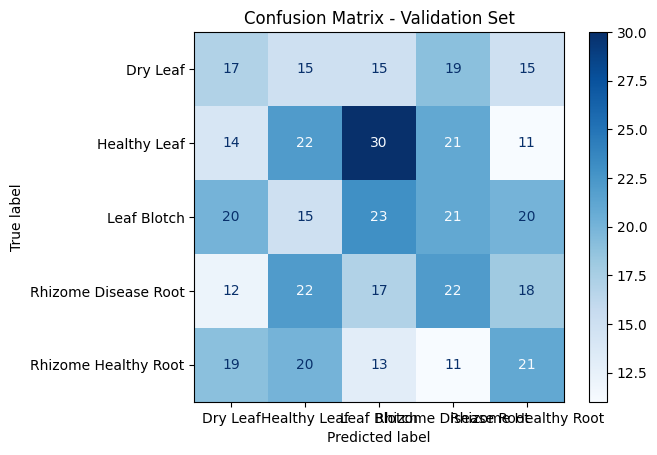

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Validation Confusion Matrix
val_pred_probs = model.predict(validation_dataset)
val_pred_classes = np.argmax(val_pred_probs, axis=1)
val_true_classes = np.concatenate([y for x, y in validation_dataset], axis=0)
val_labels = list(class_names)

cm_val = confusion_matrix(val_true_classes, val_pred_classes)

disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=val_labels)
disp_val.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()



15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.9795 - loss: 0.0426
Test loss: 0.04
Test accuracy: 0.98
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 671ms/step


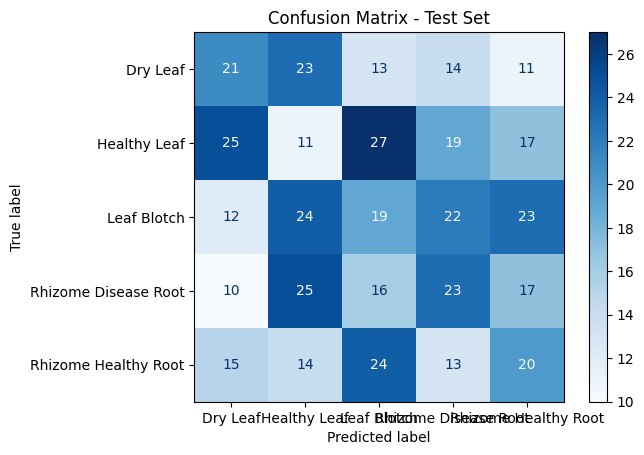

In [ ]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_dataset)
print(f"Test loss: {loss:.2f}")
print(f"Test accuracy: {accuracy:.2f}")

# Test Confusion Matrix
test_pred_probs = model.predict(test_dataset)
test_pred_classes = np.argmax(test_pred_probs, axis=1)
test_true_classes = np.concatenate([y for x, y in test_dataset], axis=0)
test_labels = list(class_names)

cm_test = confusion_matrix(test_true_classes, test_pred_classes)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=test_labels)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()



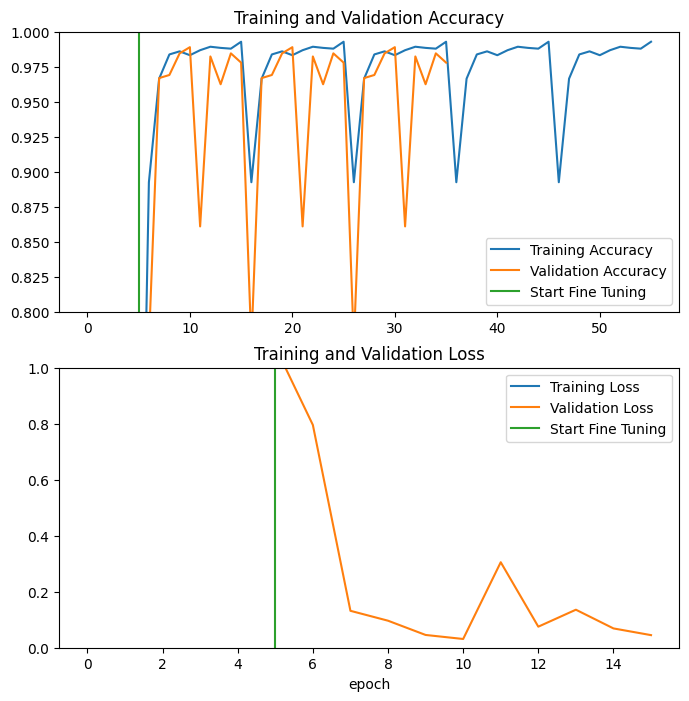

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - accuracy: 0.9820 - loss: 0.0393
Test accuracy : 0.9847161769866943


Predictions:
 [2 4 1 4 0 4 2 2 0 4 1 3 4 0 0 4 2 3 3 2 4 3 4 1 1 1 3 3 4 4 2 1]
Labels:
 [2 4 1 4 0 4 2 2 0 4 1 3 4 2 0 0 2 3 3 2 4 3 4 1 1 1 3 3 4 4 2 1]


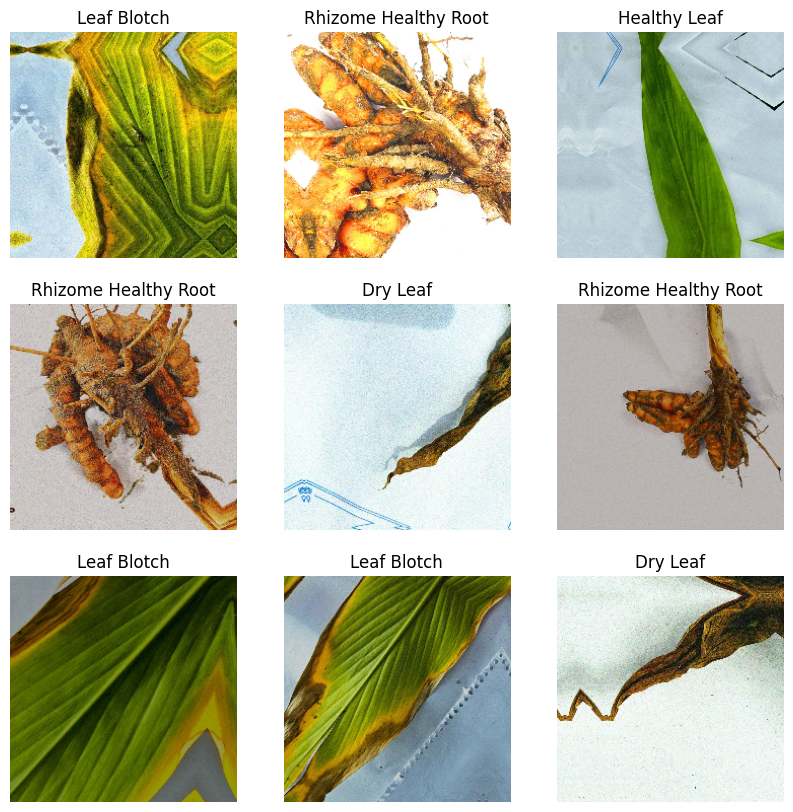

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions,axis=1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
model.save("plant_disease_recog_model_pwpresnet.keras")

In [ ]:
!find /content -name "turmeric-plant_disease_recog_model_pwp.keras"


In [ ]:
import gradio as gr
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load model
model = load_model("plant_disease_recog_model_pwpresnet.keras")

def predict_leaf(img):
    img = img.resize((224,224))
    img_array = np.array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    class_idx = np.argmax(pred)
    confidence = np.max(pred)
    class_names = ['Healthy','Leaf_Spot','Leaf_Blotch','Rhizome_Rot']

    return f"{class_names[class_idx]} ({confidence*100:.2f}%)"

# Gradio Interface
iface = gr.Interface(
    fn=predict_leaf,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Turmeric Leaf Disease Detection",
    description="Upload a turmeric leaf image and the model predicts the disease with confidence."
)

iface.launch()

ValueError: File not found: filepath=plant_disease_recog_model_pwpresnet.keras. Please ensure the file is an accessible `.keras` zip file.